In [1]:
import pandas as pd 
from pathlib import Path
from sklearn.ensemble import IsolationForest
import sys

PROJECT_ROOT = Path().resolve().parents[1]
print("Project root:", PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))
print("Project root set to:", PROJECT_ROOT)
print(Path.cwd())


# Now import
from predictor.config import load_config
config = load_config()


Project root: /home/jonas-limpert/Projects/EnviroSentinel
Project root set to: /home/jonas-limpert/Projects/EnviroSentinel
/home/jonas-limpert/Projects/EnviroSentinel/training/notebooks


In [2]:
data_path = PROJECT_ROOT / "training" / "data" / "processed_data"

dfs = {}
for file in data_path.iterdir():
    df = pd.read_csv(file)
    dfs.update({file.name.split(".")[0]: df})
print([k for k in dfs.keys()])

['PANGAEAs_SenseBox', 'Station_Kaiser', 'home_Klinga', 'Schnus_Sense_Box', 'Stadtteilbüro_Siemensstadt']


In [3]:
model = IsolationForest(
    n_estimators=100,        # Number of trees
    max_samples='auto',      # Subsampling size per tree
    contamination=0.01,      # Estimated fraction of outliers
    random_state=42
)

In [4]:
# from sklearn.preprocessing import OrdinalEncoder
# import joblib

# # Collect all unique stations and sound_bins
# all_stations = [[name] for name in dfs.keys()]
# all_sound_bins = set()

# for df in dfs.values():
#     all_sound_bins.update(df["sound_bin"].dropna().unique())

# # Fit encoders once
# sound_encoder = OrdinalEncoder()
# station_encoder = OrdinalEncoder()

# sound_encoder.fit([[s] for s in all_sound_bins])
# station_encoder.fit(all_stations)

# # Apply encodings
# for df_name, df in dfs.items():
#     df["station"] = df_name
#     df["sound_bin_encoded"] = sound_encoder.transform(df[["sound_bin"]])
#     df["station_encoded"] = station_encoder.transform(df[["station"]])
#     df = pd.get_dummies(df, columns=["sound_bin"], drop_first=True)
#     dfs[df_name] = df

# # Save encoders
# joblib.dump(sound_encoder, PROJECT_ROOT / "model/sound_encoder.pkl")
# joblib.dump(station_encoder, PROJECT_ROOT / "model/station_encoder.pkl")

In [5]:
validation_df = dfs.pop('Station_Kaiser')

combined_df = pd.concat([
    df for df in dfs.values()
    ], ignore_index=True)
    

## Encoding

In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

split_idx = int(len(combined_df) * 0.8)
train_df = combined_df.iloc[:split_idx].copy()
validation_df = combined_df.iloc[split_idx:].copy()

numeric_columns = combined_df.select_dtypes(include='number').columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[numeric_columns])
X_val_scaled = scaler.transform(validation_df[numeric_columns])

model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_train_scaled)

validation_df['anomaly'] = model.predict(X_val_scaled)
train_df['anomaly'] = model.predict(X_train_scaled)

validation_df.to_csv("/home/jonas-limpert/Projects/EnviroSentinel/training/data/validation_df.csv", index=False)


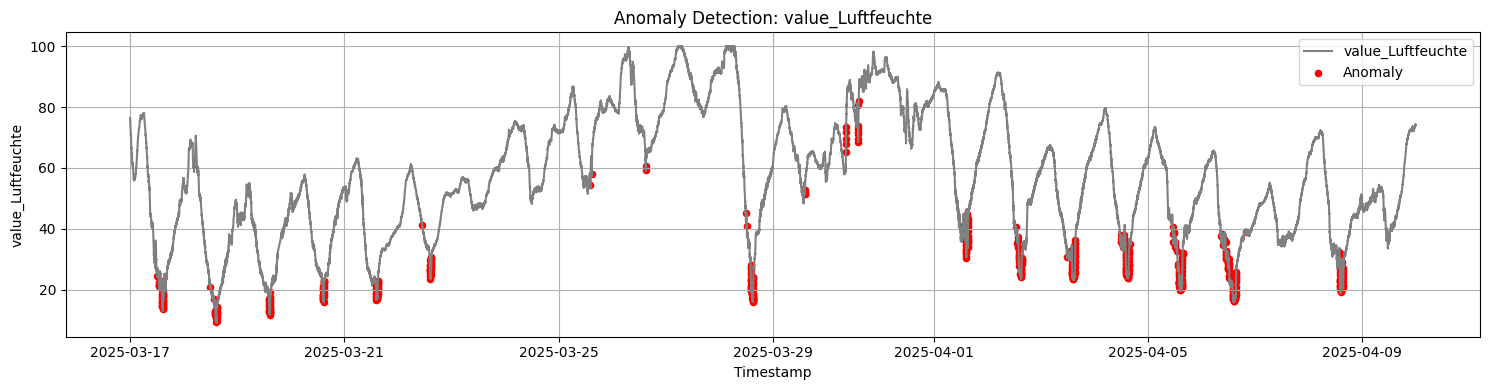

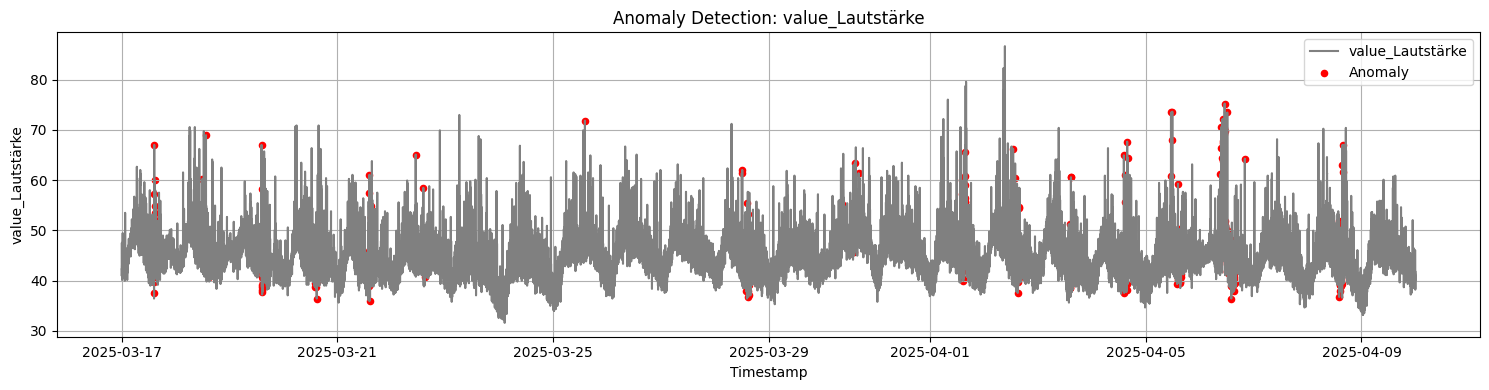

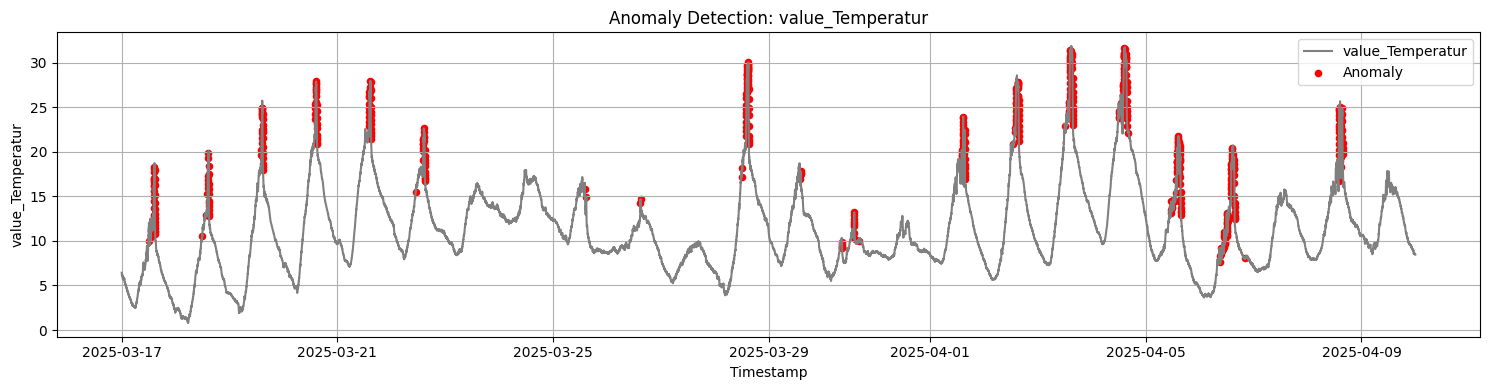

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

validation_df['timestamp'] = pd.to_datetime(validation_df['timestamp'])
validation_df.set_index('timestamp', inplace=True)

sensors_to_explore = [
    'value_Luftfeuchte',
    'value_Lautstärke',
    'value_Temperatur',
]

    

# Loop through each sensor
for sensor in sensors_to_explore:
    if sensor in validation_df.columns:
        anomalies = validation_df[validation_df['anomaly'] == -1]
        
        plt.figure(figsize=(15, 4))
        plt.plot(validation_df.index, validation_df[sensor], label=sensor, color='gray')
        plt.scatter(anomalies.index, anomalies[sensor], color='red', label='Anomaly', s=20)
        plt.title(f"Anomaly Detection: {sensor}")
        plt.xlabel("Timestamp")
        plt.ylabel(sensor)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



['PANGAEAs_SenseBox' 'home_Klinga' 'Schnus_Sense_Box'
 'Stadtteilbüro_Siemensstadt']


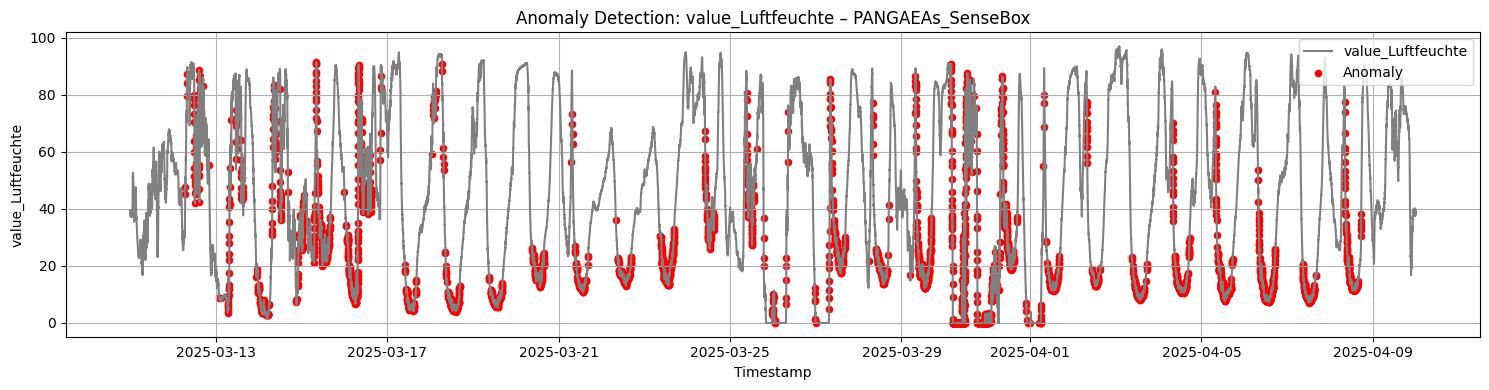

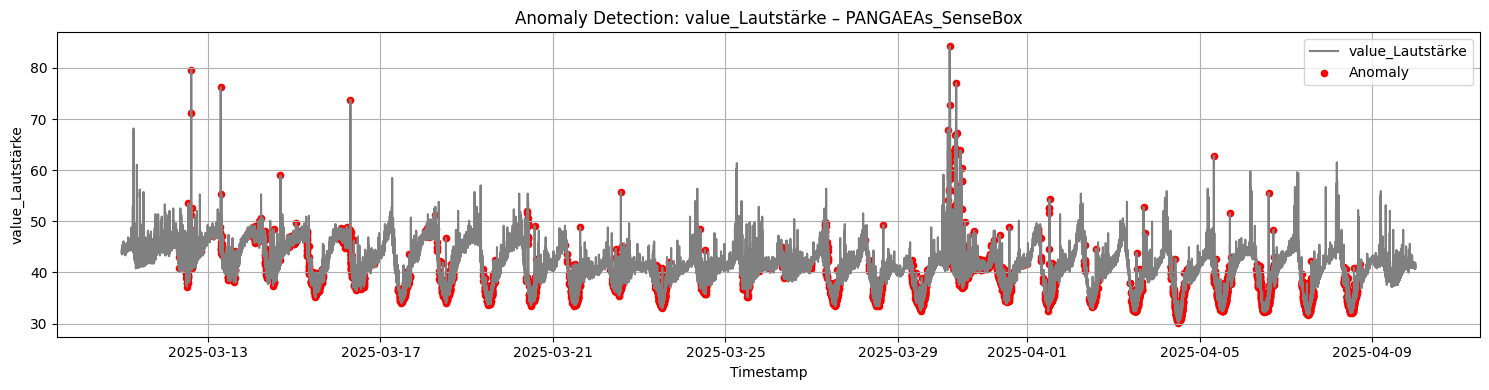

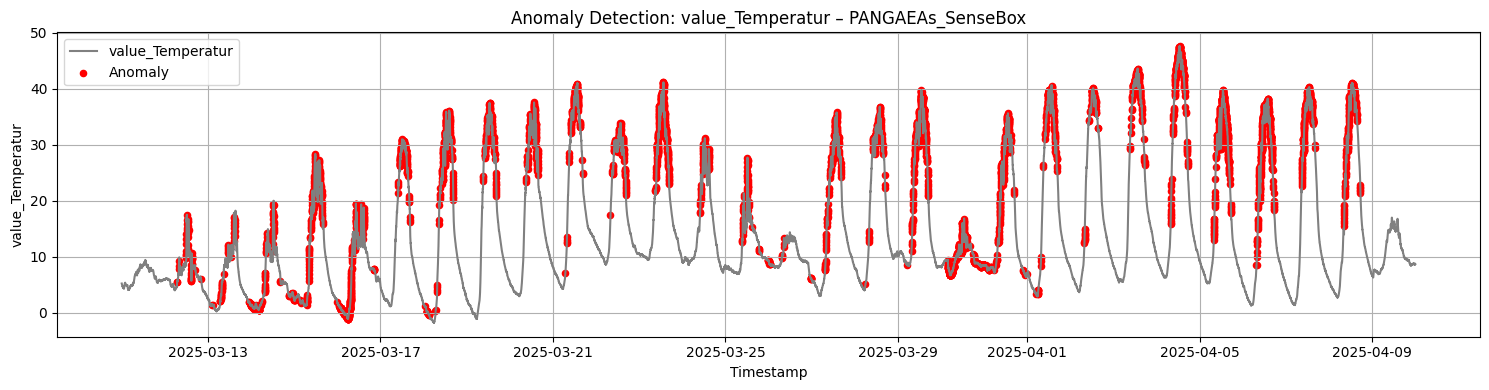

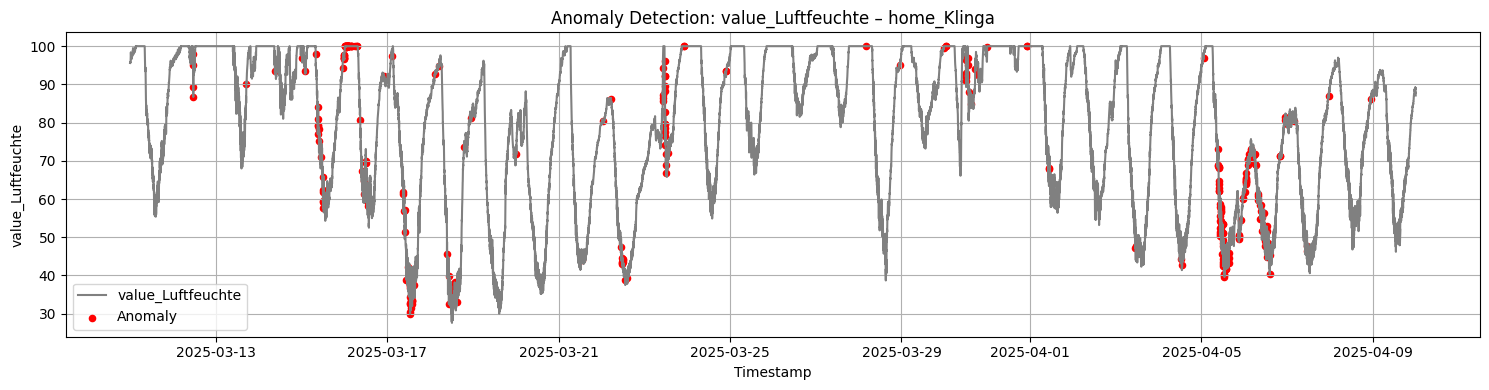

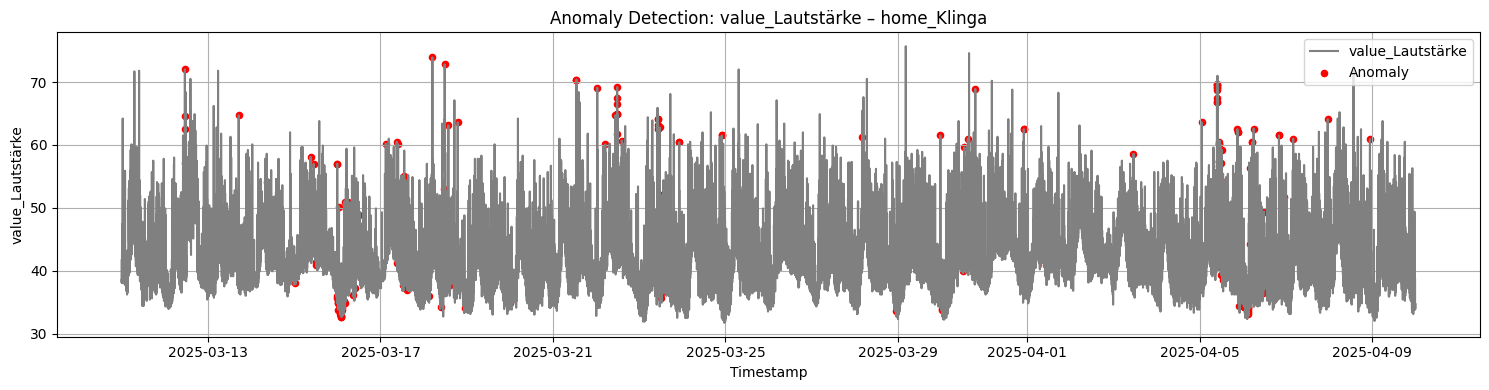

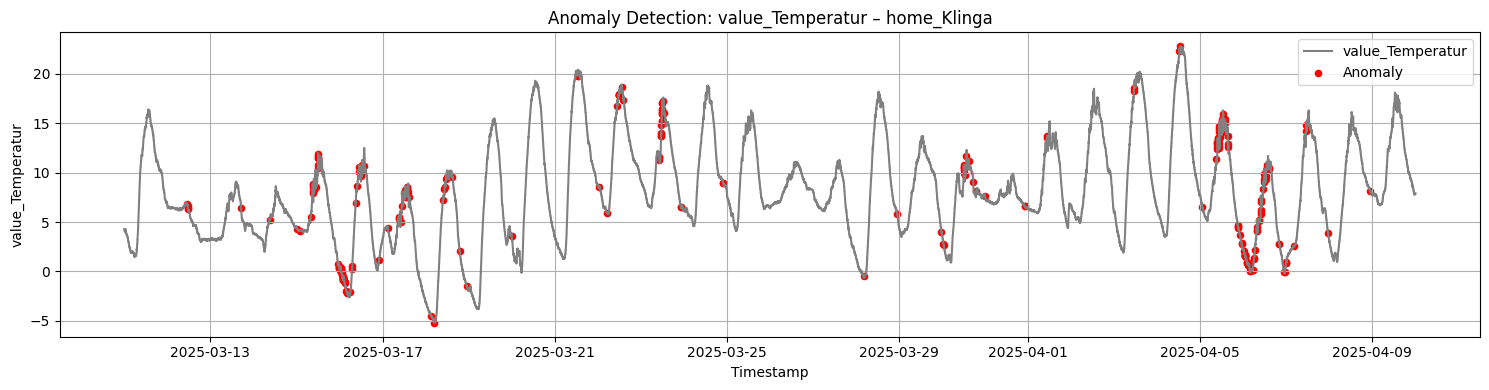

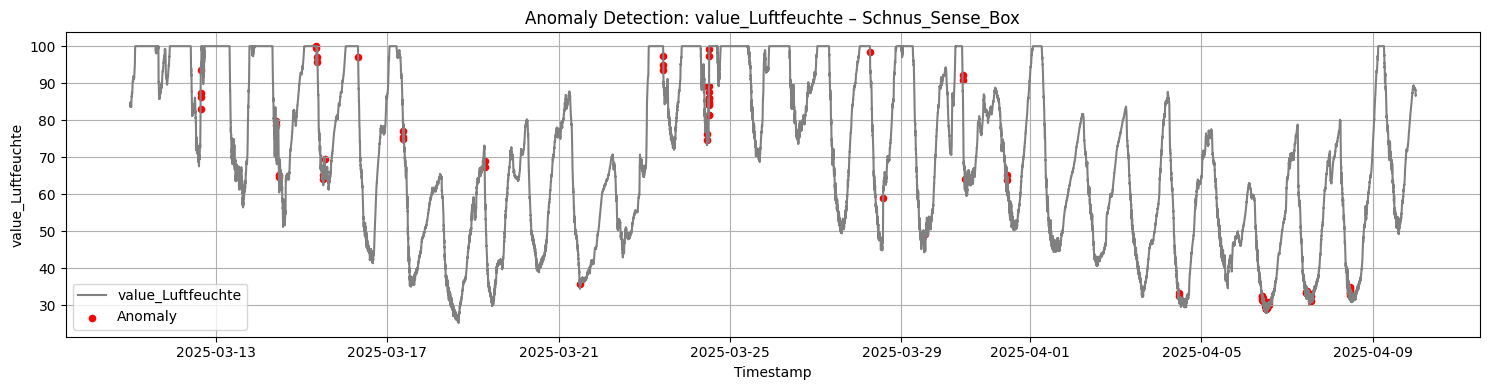

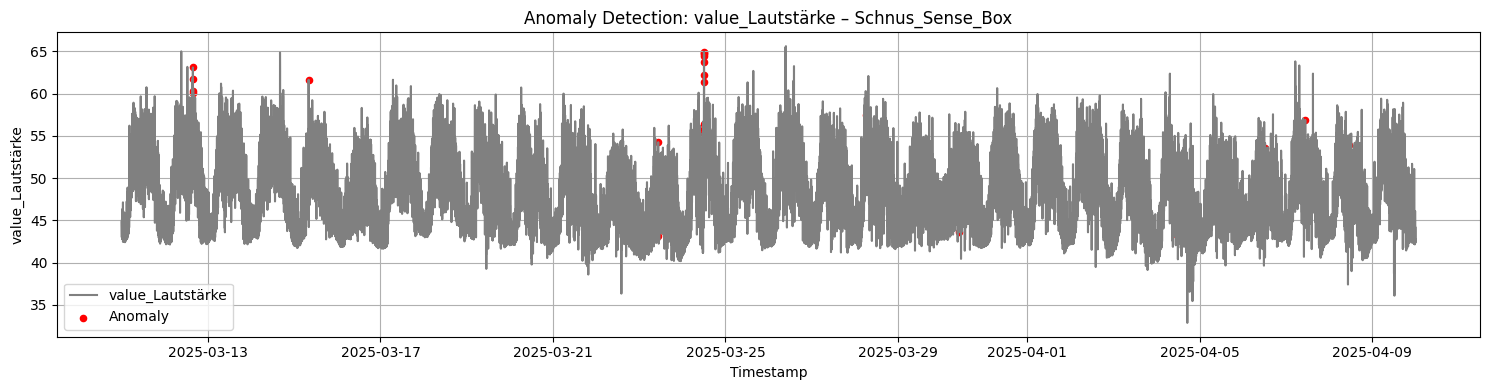

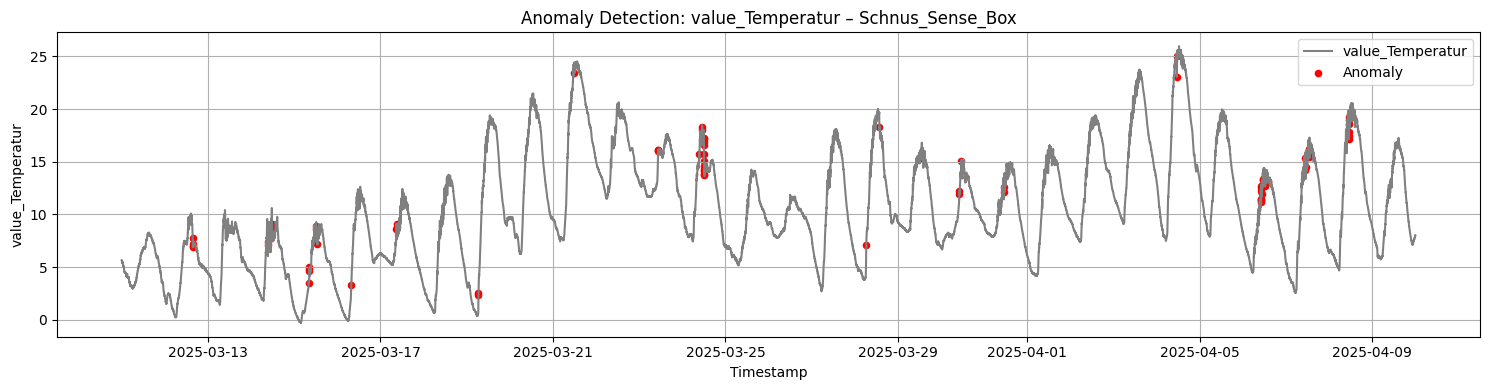

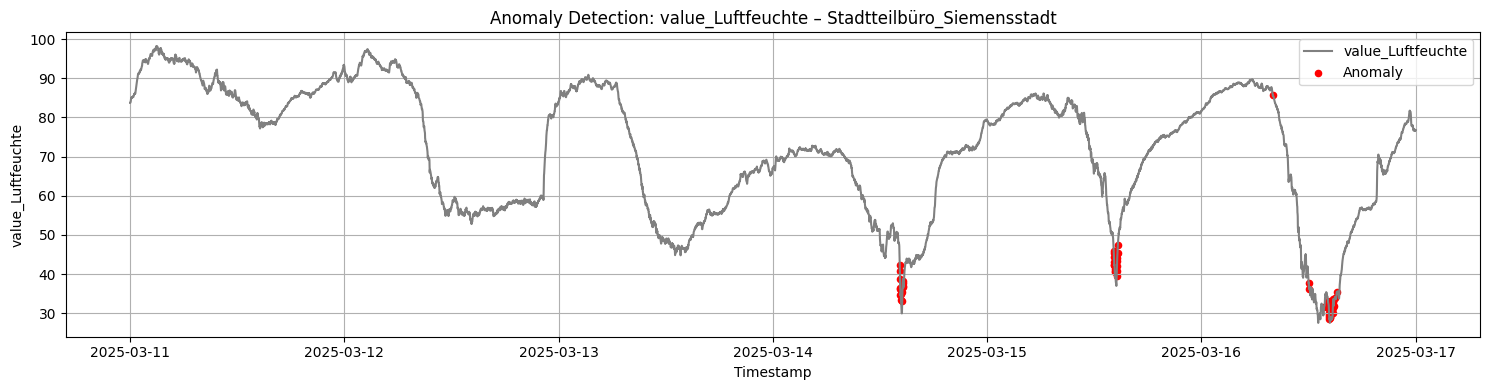

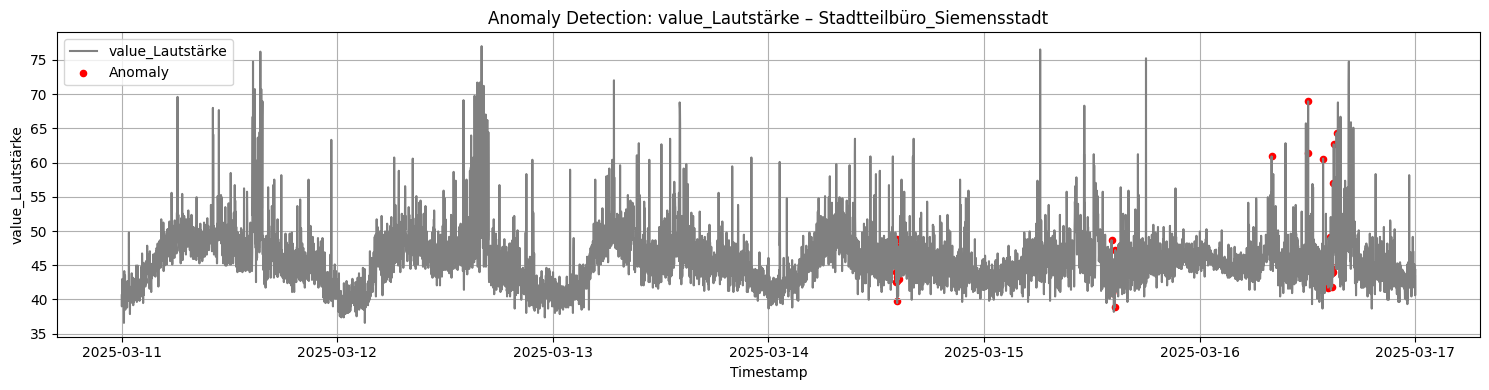

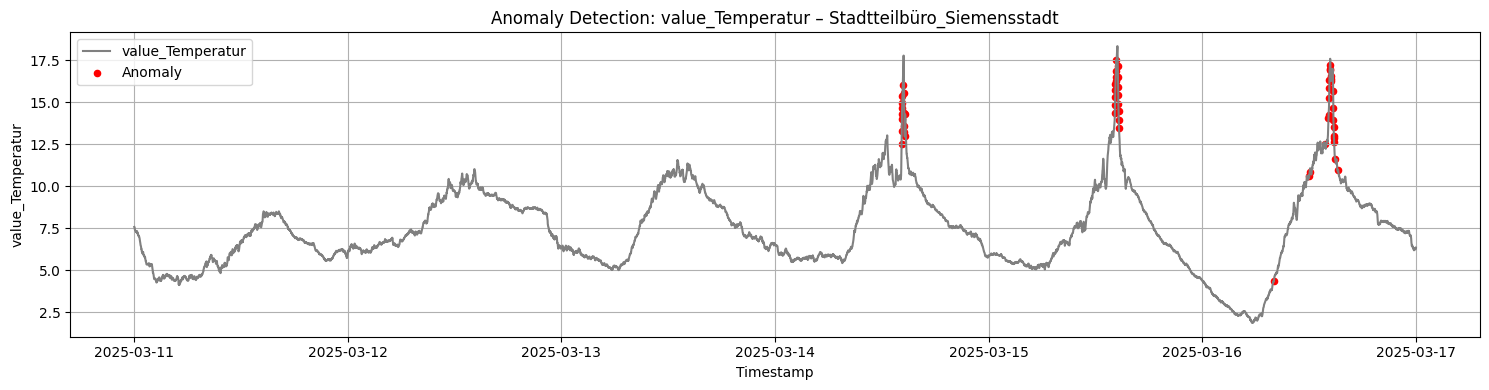

In [8]:
from predictor.src.preprocessor import Preprocessor

# Step 1: Ensure timestamp is datetime and used as index
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df.set_index('timestamp', inplace=True)

# Step 2: Define which sensors to visualize
sensors_to_explore = [
    'value_Luftfeuchte',
    'value_Lautstärke',
    'value_Temperatur',
]

preprocessor = Preprocessor(is_training=False, sound_encoder_path=config.SOUND_ENCODER_PATH, station_encoder_path=config.STATION_ENCODER_PATH)

train_df = preprocessor.decode_dataframe(train_df)
print(train_df['station'].unique())
# Step 3: Loop over each station and each sensor
for station_name in train_df['station'].unique():
    station_df = train_df[train_df['station'] == station_name]
    
    for sensor in sensors_to_explore:
        if sensor in station_df.columns:
            anomalies = station_df[station_df['anomaly'] == -1]
            
            plt.figure(figsize=(15, 4))
            plt.plot(station_df.index, station_df[sensor], label=sensor, color='gray')
            plt.scatter(anomalies.index, anomalies[sensor], color='red', label='Anomaly', s=20)
            plt.title(f"Anomaly Detection: {sensor} – {station_name}")
            plt.xlabel("Timestamp")
            plt.ylabel(sensor)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()



In [9]:
from pathlib import Path
import joblib
ModelPath = PROJECT_ROOT / 'model'
ModelPath.mkdir(parents=True, exist_ok=True)
# Save model
joblib.dump(model, ModelPath / 'isolation_forest_model.pkl')

# Save scaler (if you're using StandardScaler or similar)
joblib.dump(scaler, ModelPath / 'scaler.pkl')

['/home/jonas-limpert/Projects/EnviroSentinel/model/scaler.pkl']